In [1]:
from torchvision.io.image import read_image
from torchvision.models import detection
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch

In [2]:
import numpy as np

In [3]:
from optparse import OptionParser
import inspect

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids
import datetime
import time

import pydicom as dicom
import cv2

from medpy.io import load
import medpy

import os
from os import listdir
from os.path import isfile, join

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/arhitegio/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [6]:
import numpy as np
import pandas as pd
import os
import numpy as np
import pandas as pd
import scipy.io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
gc.collect()

import os
#print(os.listdir("./Mask"))

In [8]:
params = {
    "path_dicom":"./lola11-01/",
    "path_mask":"./Mask/",
    "width":284,
    "height":284,
    "width_out":196,
    "height_out":196,
    "device": torch.device("cuda:2" if torch.cuda.is_available() else "cpu"),
}

In [9]:
def found_files(path):
    return [f for f in listdir(path) if isfile(join(path, f))]

In [10]:
mage_data, image_header = medpy.io.load('./Lola11/lola11-01.mha')

In [11]:
np.shape(mage_data)[2]

464

In [12]:
masks_paths = [[int(e.split('.')[0].split('_')[-1])+1, e] for e in found_files(params['path_mask'])]
masks_paths = sorted(masks_paths, key=lambda x: x[0])

In [13]:
dic_paths = {}
for idx, path in masks_paths:
    if idx < np.shape(mage_data)[2]:
        dic_paths[idx] = [os.path.join(params['path_mask'],path)]
    
dic_paths

{1: ['./Mask/0.nii'],
 2: ['./Mask/1.nii'],
 3: ['./Mask/2.nii'],
 4: ['./Mask/3.nii'],
 5: ['./Mask/4.nii'],
 6: ['./Mask/5.nii'],
 7: ['./Mask/6.nii'],
 8: ['./Mask/7.nii'],
 9: ['./Mask/8.nii'],
 10: ['./Mask/9.nii'],
 11: ['./Mask/10.nii'],
 12: ['./Mask/11.nii'],
 13: ['./Mask/12.nii'],
 14: ['./Mask/13.nii'],
 15: ['./Mask/14.nii'],
 16: ['./Mask/15.nii'],
 17: ['./Mask/16.nii'],
 18: ['./Mask/17.nii'],
 19: ['./Mask/18.nii'],
 20: ['./Mask/19.nii'],
 21: ['./Mask/20.nii'],
 22: ['./Mask/21.nii'],
 23: ['./Mask/22.nii'],
 24: ['./Mask/23.nii'],
 25: ['./Mask/24.nii'],
 26: ['./Mask/25.nii'],
 27: ['./Mask/26.nii'],
 28: ['./Mask/27.nii'],
 29: ['./Mask/28.nii'],
 30: ['./Mask/29.nii'],
 31: ['./Mask/30.nii'],
 32: ['./Mask/31.nii'],
 33: ['./Mask/32.nii'],
 34: ['./Mask/33.nii'],
 35: ['./Mask/34.nii'],
 36: ['./Mask/35.nii'],
 37: ['./Mask/36.nii'],
 38: ['./Mask/37.nii'],
 39: ['./Mask/38.nii'],
 40: ['./Mask/39.nii'],
 41: ['./Mask/40.nii'],
 42: ['./Mask/41.nii'],
 43: ['./Ma

In [14]:
np.unique(np.load(dic_paths[100][0]))

array([0., 1., 4., 5.])

In [15]:
255/5

51.0

[0. 1. 2. 3. 4. 5.]
(517, 517, 4) (512, 512)


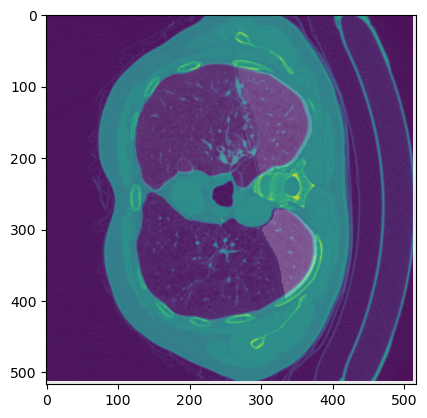

In [16]:
img = np.load(dic_paths[310][0])
print(np.unique(img))
img += 5
img /= np.max(img)
ds = mage_data[:,:,310]
print(np.shape(img),np.shape(ds))
plt.imshow(ds,alpha=1.0)
plt.imshow(img,alpha=0.3)
plt.show()

In [17]:
img = np.load(dic_paths[310][0])
class_ = np.unique(img[:,:,3])
class_

array([0., 1., 2., 3., 4., 5.])

In [18]:
class_ = class_[np.newaxis, 1:]
class_

array([[1., 2., 3., 4., 5.]])

In [19]:
np.shape((img[:,:,3][:,:,np.newaxis] == class_).astype(int))

(517, 517, 5)

(517, 517) (512, 512)


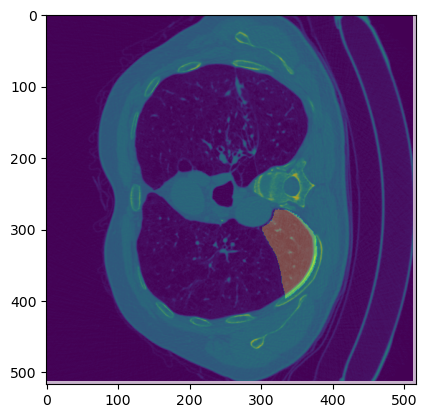

In [20]:
img_ = (img[:,:,3][:,:,np.newaxis] == class_).astype(int)[...,4]
ds = mage_data[:,:,310]
print(np.shape(img_),np.shape(ds))
plt.imshow(ds,alpha=1.0)
plt.imshow(img_,alpha=0.3)
plt.show()

In [21]:
len([e for e in range(0, 512, 2)])

256

In [22]:
def change_size(arr):
    mask = [e for e in range(0, np.shape(arr)[0], 2)]
    tmp = arr[mask,:,:]
    return tmp[:,mask,:]

In [23]:
import random

def thresh(x):
    if x == 0:
        return 0
    else:
        return 1
    
    
def create_datasets(x_data, y_data, pr = 0.2):
    x = []
    y = []
    x_val = []
    y_val = []
    for idx in tqdm(range(np.shape(x_data)[2])):
        if idx+1 in y_data.keys():
            y_d = (np.array(np.load(y_data[idx+1][0]), dtype=np.float16)[:,:,0][:,:,np.newaxis] == class_).astype(int)
            y_mx = y_d if np.shape(y_d)[1] == 512 else y_d[0:512,4:516,:]
            x_mx = change_size(change_size(np.array(x_data[:,:,idx][:,:, np.newaxis], dtype=np.float16)))
            if random.random() <= 0.2:
                y_val.append(y_mx)
                x_val.append(x_mx)
            else:
                y.append(y_mx)
                x.append(x_mx)
    return np.array(x), np.array(y), np.array(x_val), np.array(y_val)

x_train, y_train, x_val, y_val = create_datasets(mage_data, dic_paths)

100%|█████████████████████████████████████████| 464/464 [00:11<00:00, 41.90it/s]


In [24]:
np.shape(x_train)

(376, 128, 128, 1)

In [25]:
x_train = np.moveaxis(x_train, -1,1)
y_train = np.moveaxis(y_train, -1,1)

In [96]:
x_val = np.moveaxis(x_val, -1,1)
y_val = np.moveaxis(y_val, -1,1)

In [26]:
x_train.shape, y_train.shape

((376, 1, 128, 128), (376, 5, 512, 512))

In [27]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from tqdm import trange
from time import sleep
use_gpu = torch.cuda.is_available()

In [100]:
batch_size = 6
epochs = 10
epoch_lapse = 50
threshold = 0.5
sample_size = None

In [29]:
def jaccard(a, b):
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [30]:
t = torch.Tensor([1, 2, 3])
print ((t == 2).nonzero(as_tuple=True)[0])

tensor([1])


In [43]:
class ASPPBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=(1, 1), in_channels=channels, out_channels=channels, padding=0)
        self.conv2 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=6, dilation=(6, 6))
        #self.conv3 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=12, dilation=(12,12))
        #self.conv4 = torch.nn.Conv2d(kernel_size=(3, 3), in_channels=channels, out_channels=channels, padding=18, dilation=(18,18))
        self.conv5 = torch.nn.Conv2d(kernel_size=(1, 1), in_channels=channels*4, out_channels=channels)
        
    def forward(self, inp):
        out1 = torch.nn.functional.relu(self.conv1(inp))
        #print(f"out1",np.shape(out1))
        out2 = torch.nn.functional.relu(self.conv2(inp))
        #print(f"out2",np.shape(out2))
        out3 = torch.nn.functional.relu(self.conv3(inp))
        #print(f"out3",np.shape(out3))
        out4 = torch.nn.functional.relu(self.conv4(inp))
        #print(f"out4",np.shape(out4))
        out = torch.cat((out1, out2, out3, out4), dim=1)
        #out = torch.cat((out1, out2), dim=1)
        #print(f"out",np.shape(out))
        out = torch.nn.functional.relu(self.conv5(out))
        return out

In [44]:
class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(out_channels)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(out_channels)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        return out

In [45]:
class Bottlenack(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=3, in_channels=in_channels, out_channels=in_channels*2, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(in_channels*2)
        self.conv2 = torch.nn.Conv2d(kernel_size=3, in_channels=in_channels*2, out_channels=in_channels*2, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(in_channels*2)
        self.conv3 = torch.nn.ConvTranspose2d(kernel_size=3, in_channels=in_channels*2, out_channels=in_channels,stride=2, padding=1, output_padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.relu(self.conv3(out))
        return out

In [46]:
class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super().__init__()
        mid_channel = min(in_channels, out_channels) + max(in_channels, out_channels) - min(in_channels, out_channels)
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.conv3 = torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.relu(self.conv3(out))
        return out

In [47]:
class FinalBlock(nn.Module):
    def __init__(self, in_channels, mid_channel, out_channels, kernel_size=3):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel, padding=1)
        self.bn2d1 = torch.nn.BatchNorm2d(mid_channel)
        self.conv2 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel, padding=1)
        self.bn2d2 = torch.nn.BatchNorm2d(mid_channel)
        self.conv3 = torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1)
        
    def forward(self, inp):
        out = torch.nn.functional.relu(self.conv1(inp))
        out = self.bn2d1(out)
        out = torch.nn.functional.relu(self.conv2(out))
        out = self.bn2d2(out)
        out = torch.nn.functional.sigmoid(self.conv3(out))
        return out

In [48]:
class UNet(nn.Module):    
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        self.conv1 = DownSampling(in_channels, 64, 3)
        self.conv2 = DownSampling(64, 128, 3)
        self.conv3 = DownSampling(128, 256, 3)
        self.bottleneck = Bottlenack(256)
        self.convT1 = UpSampling(in_channels=256,out_channels=192, kernel_size=3)
        self.convT2 = UpSampling(in_channels=192,out_channels=128, kernel_size=3)
        self.convT3 = UpSampling(in_channels=128,out_channels=96,  kernel_size=3)
        self.convT4 = UpSampling(in_channels=96, out_channels=64,  kernel_size=3)
        self.aspp = ASPPBlock(64)
        self.final = FinalBlock(64, 16, out_channels)
        self.conv_maxpool = torch.nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x):
        #print(np.shape(x))
        x = self.conv1(x)
        x = self.conv_maxpool(x)
        #print(f"conv1", np.shape(x))
        x = self.conv2(x)
        x = self.conv_maxpool(x)
        #print(f"conv2", np.shape(x))
        x = self.conv3(x)
        x = self.conv_maxpool(x)
        #print(f"conv3", np.shape(x))
        x = self.bottleneck(x)
        #print(f"bottleneck", np.shape(x))
        x = self.convT1(x)
        #print(f"convT1", np.shape(x))
        x = self.convT2(x)
        #print(f"convT2", np.shape(x))
        x = self.convT3(x)
        #print(f"convT3", np.shape(x))
        x = self.convT4(x)
        #print(f"convT4", np.shape(x))
        #x = self.aspp(x)
        #print(f"aspp", np.shape(x))
        x = self.final(x)
        #print(f"final", np.shape(x))
        return x

In [49]:
def train_step(inputs, labels, optimizer, criterion):
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = unet(inputs)
    outputs = outputs.permute(0, 2, 3, 1)
    labels = labels.permute(0, 2, 3, 1)
    #print(np.shape(outputs))
    #print(np.shape(labels))
    #print("Точность ", jaccard(outputs, labels))
    #loss = criterion((outputs> 0.5).float(), labels.float())
    loss = criterion(outputs, labels.float())
    loss.backward()
    optimizer.step()
    return loss

In [50]:
learning_rate = 0.0001

In [51]:
unet = UNet(in_channels=1,out_channels=np.shape(class_)[-1])
if use_gpu:
    unet = unet.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr = learning_rate)

In [61]:
try:
    print(unet.load_state_dict(torch.load('./best_model.mdl')))
except:
    print("Модель не загрузилась")

<All keys matched successfully>


In [46]:
def get_val_loss(x_val, y_val):
    x_val = torch.from_numpy(x_val).float()
    y_val = torch.from_numpy(y_val).long()
    if use_gpu:
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    m = x_val.shape[0]
    outputs = unet(x_val)
    # outputs.shape = (batch_size, n_classes, img_cols, img_rows) 
    outputs = outputs.permute(0, 2, 3, 1)
    # outputs.shape = (batch_size, img_cols, img_rows, n_classes) 
    outputs = outputs.resize(m*width_out*height_out, 2)
    labels = y_val.resize(m*width_out*height_out)
    loss = F.cross_entropy(outputs, labels)
    return loss.data

In [64]:
learning_rate = 0.00005

In [65]:
criterion = nn.BCELoss()

In [66]:
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_
from tqdm.notebook import tqdm as tqdm_step

In [102]:
%%time
unet.train()
epoch_iter = np.ceil(x_train.shape[0] / batch_size).astype(int)
t = trange(epochs, leave=True)
for _ in tqdm_step(t, desc="Epochs"):
    total_loss = 0
    for i in tqdm_step(range(epoch_iter), desc="Training"):
        batch_train_x = torch.from_numpy(x_train[i * batch_size : (i + 1) * batch_size, ...]).float()
        batch_train_y = torch.from_numpy(y_train[i * batch_size : (i + 1) * batch_size]).long()
        if use_gpu:
            batch_train_x = batch_train_x.cuda()
            batch_train_y = batch_train_y.cuda()
        batch_loss = train_step(batch_train_x, batch_train_y, optimizer, criterion)
        total_loss += batch_loss
    if (_+1) % epoch_lapse == 0:
        val_loss = get_val_loss(x_val, y_val)
        print(f"Total loss in epoch {_+1} : { total_loss / epoch_iter } and validation loss : {val_loss}")

  0%|                                                    | 0/10 [00:00<?, ?it/s]

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 10%|████▍                                       | 1/10 [01:34<14:07, 94.17s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 20%|████████▊                                   | 2/10 [03:09<12:37, 94.73s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 30%|█████████████▏                              | 3/10 [04:44<11:04, 94.94s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 40%|█████████████████▌                          | 4/10 [06:19<09:30, 95.08s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 50%|██████████████████████                      | 5/10 [07:55<07:55, 95.16s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 60%|██████████████████████████▍                 | 6/10 [09:30<06:20, 95.21s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 70%|██████████████████████████████▊             | 7/10 [11:05<04:45, 95.24s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 80%|███████████████████████████████████▏        | 8/10 [12:40<03:10, 95.26s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

 90%|███████████████████████████████████████▌    | 9/10 [14:16<01:35, 95.30s/it]

Training:   0%|          | 0/63 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 10/10 [15:51<00:00, 95.16s/it]

CPU times: user 16min 26s, sys: 4.84 s, total: 16min 31s
Wall time: 15min 51s


In [101]:
#with open("./last.state", "w") as f:
#    f.write(json.dumps({"val_acc":val_acc.item()}))
if os.path.exists("./best_model.mdl"):
    os.rename('./best_model.mdl', f'./model_{1}.mdl')
torch.save(unet.state_dict(), './best_model.mdl')
print('Сохранено!')

Сохранено!


In [82]:
gc.collect()

75348

In [93]:
def plot_examples(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=11, figsize=(18,4*num_examples))
    m = datax.shape[0]
    p = 0.4
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        image_arr = image_arr/ np.max(image_arr)
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].set_title("Orignal Image")
        ax[row_num][1].imshow((np.transpose(image_arr, (1,2,0))[:,:,0] > p).astype(int))
        ax[row_num][1].set_title("Segmented Image")
        ax[row_num][2].imshow((np.transpose(image_arr, (1,2,0))[:,:,1] > p).astype(int))
        ax[row_num][2].set_title("Segmented Image")
        ax[row_num][3].imshow((np.transpose(image_arr, (1,2,0))[:,:,2] > p).astype(int))
        ax[row_num][3].set_title("Segmented Image")
        ax[row_num][4].imshow((np.transpose(image_arr, (1,2,0))[:,:,3] > p).astype(int))
        ax[row_num][4].set_title("Segmented Image")
        ax[row_num][5].imshow((np.transpose(image_arr, (1,2,0))[:,:,4] > p).astype(int))
        ax[row_num][5].set_title("Segmented Image")
        #print(np.shape(image_arr))
        img = np.argmax(np.transpose(image_arr, (1,2,0)), axis=-1)
        img += 5
        #print(np.shape(img), np.max(img))
        img = img / np.max(img)
        img *= 255
        #ax[row_num][6].imshow(img)
        #ax[row_num][6].set_title("Segmented Image localization")
        ax[row_num][6].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0])
        ax[row_num][6].set_title("Target image")
        ax[row_num][7].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,1])
        ax[row_num][7].set_title("Target image")
        ax[row_num][8].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,2])
        ax[row_num][8].set_title("Target image")
        ax[row_num][9].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,3])
        ax[row_num][9].set_title("Target image")
        ax[row_num][10].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,4])
        ax[row_num][10].set_title("Target image")
    plt.show()

In [94]:
def plot_examples_all(datax, datay, num_examples=3):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,4*num_examples))
    m = datax.shape[0]
    p = 0.4
    for row_num in range(num_examples):
        image_indx = np.random.randint(m)
        image_arr = unet(torch.from_numpy(datax[image_indx:image_indx+1]).float().cuda()).squeeze(0).detach().cpu().numpy()
        image_arr = image_arr/ np.max(image_arr)
        ax[row_num][0].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0])
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,0] > p).astype(int), alpha=.2, cmap = 'gray')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,1] > p).astype(int), alpha=.2, cmap = 'RdPu_r')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,2] > p).astype(int), alpha=.2, cmap = 'BuGn_r')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,3] > p).astype(int), alpha=.2, cmap = 'YlGn')
        ax[row_num][0].imshow((np.transpose(image_arr, (1,2,0))[:,:,4] > p).astype(int), alpha=.2, cmap = 'coolwarm')
        ax[row_num][0].set_title("Predict")
        #print(np.shape(image_arr))
        img = np.argmax(np.transpose(image_arr, (1,2,0)), axis=-1)
        img += 5
        #print(np.shape(img), np.max(img))
        img = img / np.max(img)
        img *= 255
        #ax[row_num][6].imshow(img)
        #ax[row_num][6].set_title("Segmented Image localization")
        ax[row_num][1].imshow(np.transpose(datax[image_indx], (1,2,0))[:,:,0], )
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,0], alpha=.2, cmap = 'gray')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,1], alpha=.2, cmap = 'RdPu_r')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,2], alpha=.2, cmap = 'BuGn_r')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,3], alpha=.2, cmap = 'YlGn')
        ax[row_num][1].imshow(np.transpose(datay[image_indx], (1,2,0))[:,:,4], alpha=.2, cmap = 'coolwarm')
        ax[row_num][1].set_title("Original")
    plt.show()

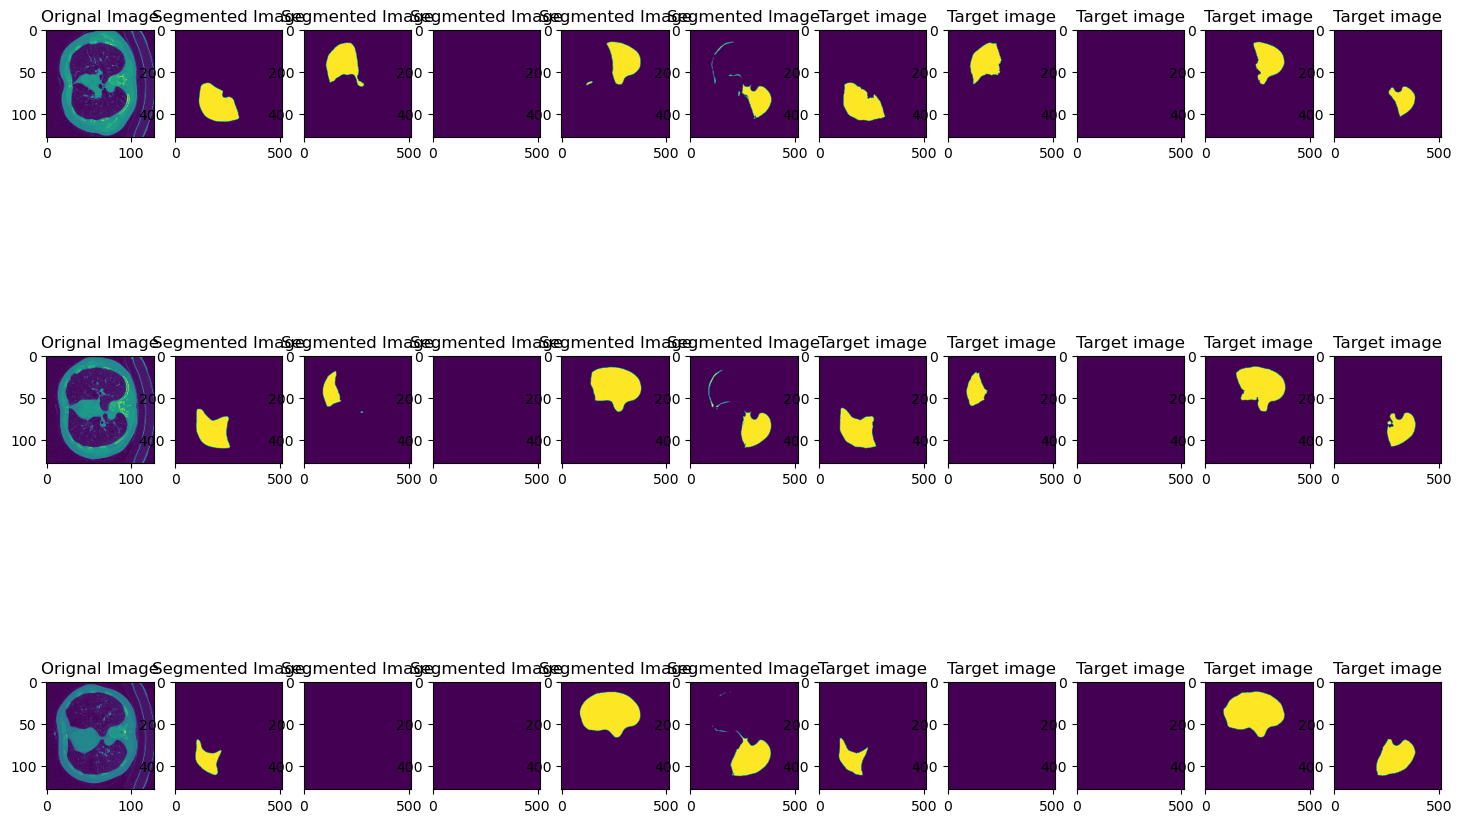

In [109]:
plot_examples(x_train, y_train)

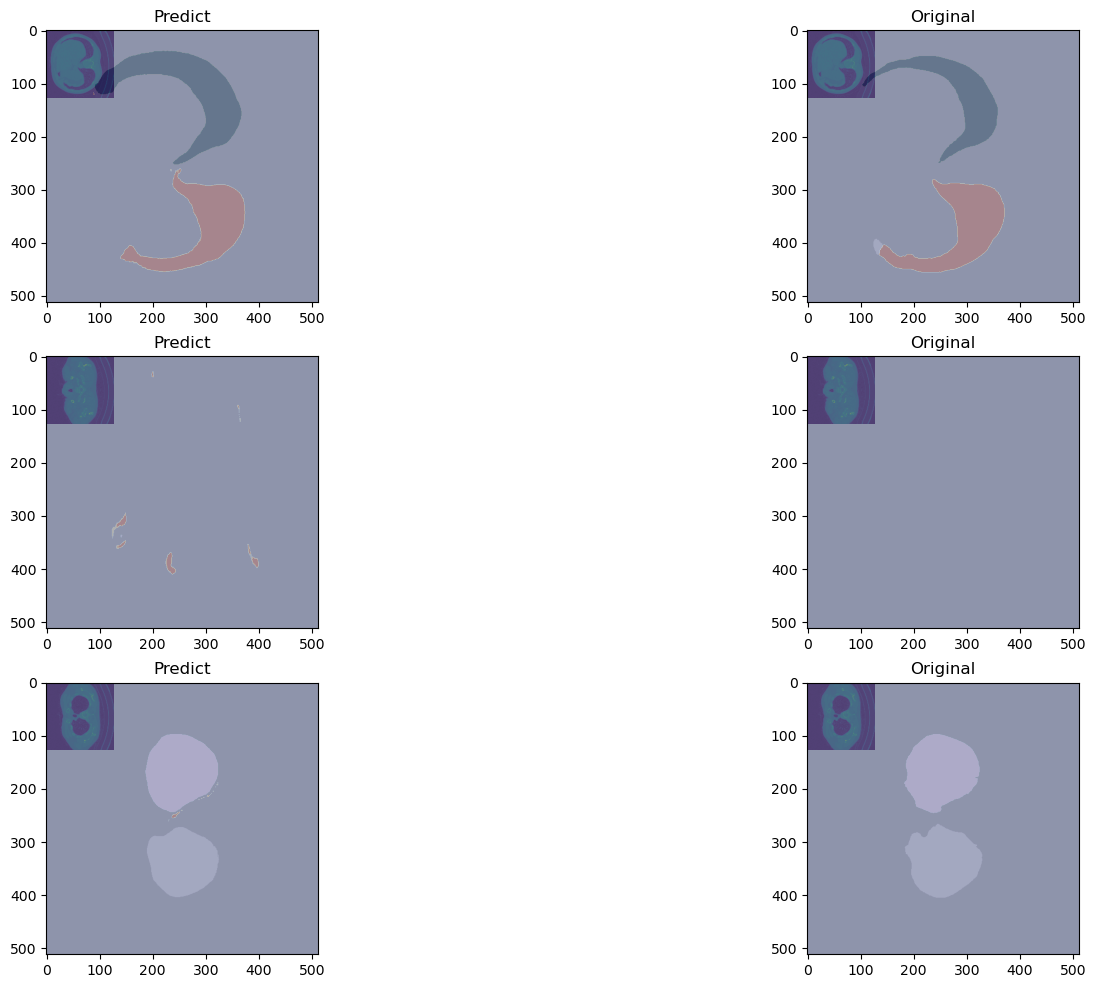

In [113]:
plot_examples_all(x_train, y_train)

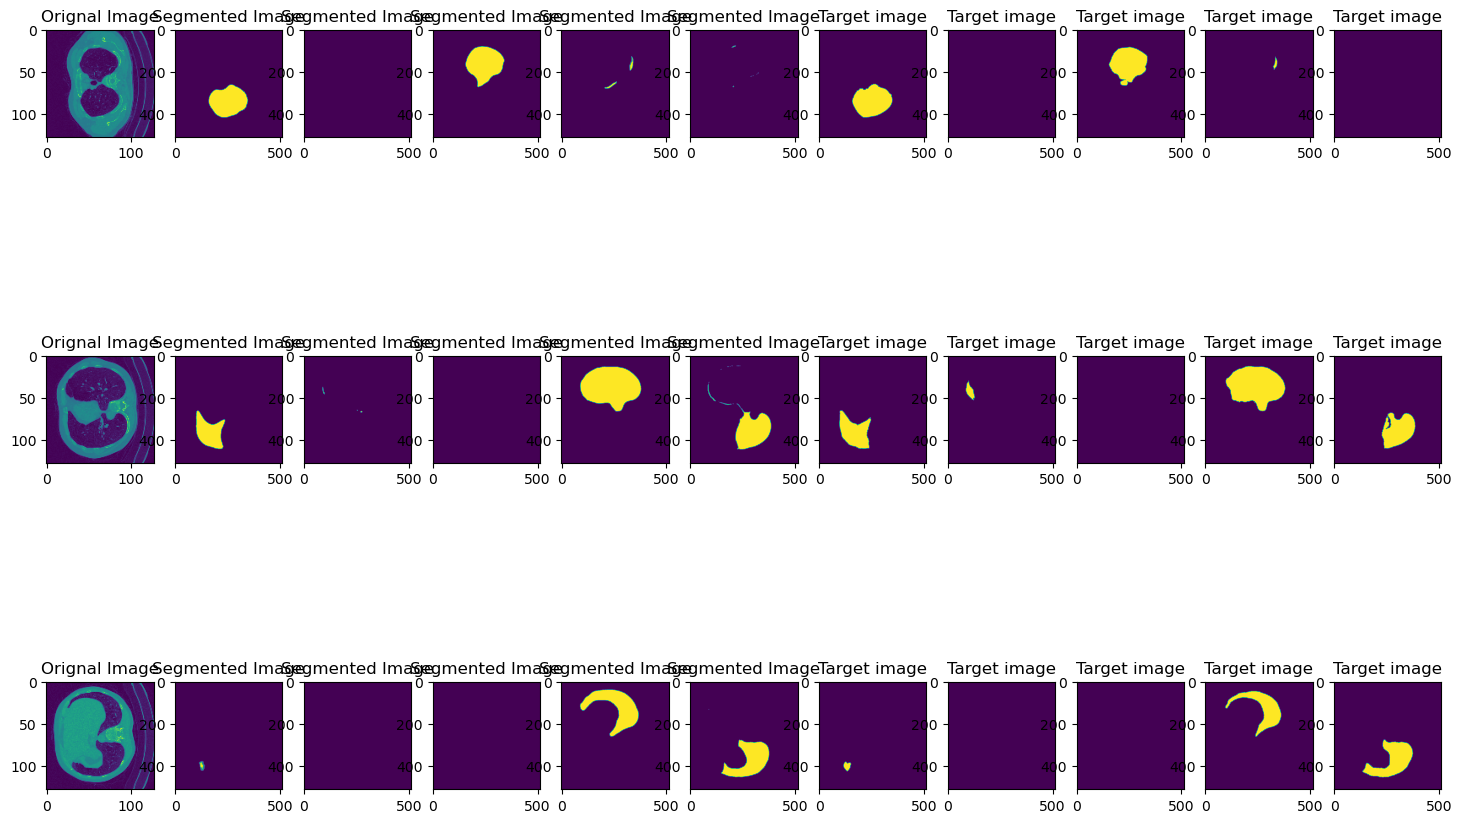

In [107]:
plot_examples(x_val, y_val)

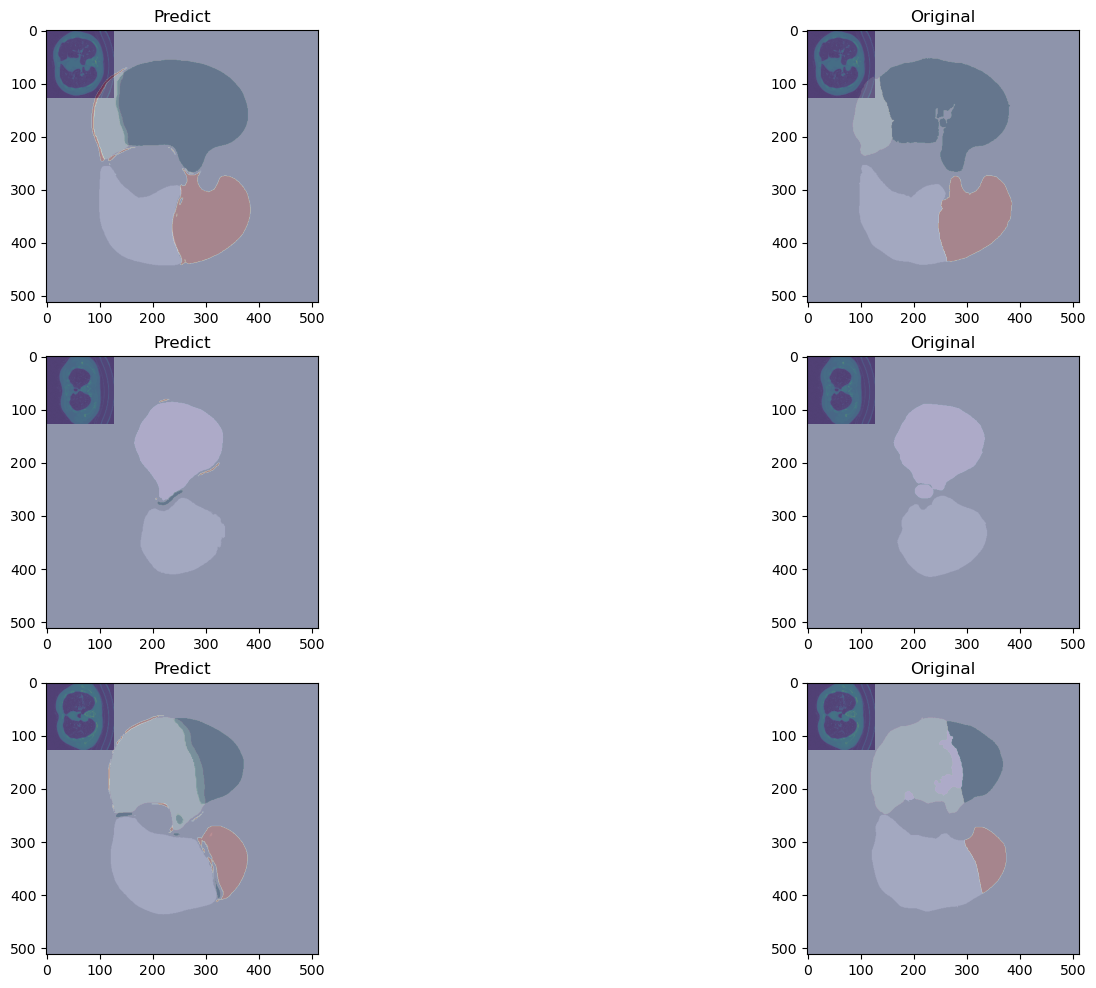

In [116]:
plot_examples_all(x_val, y_val)

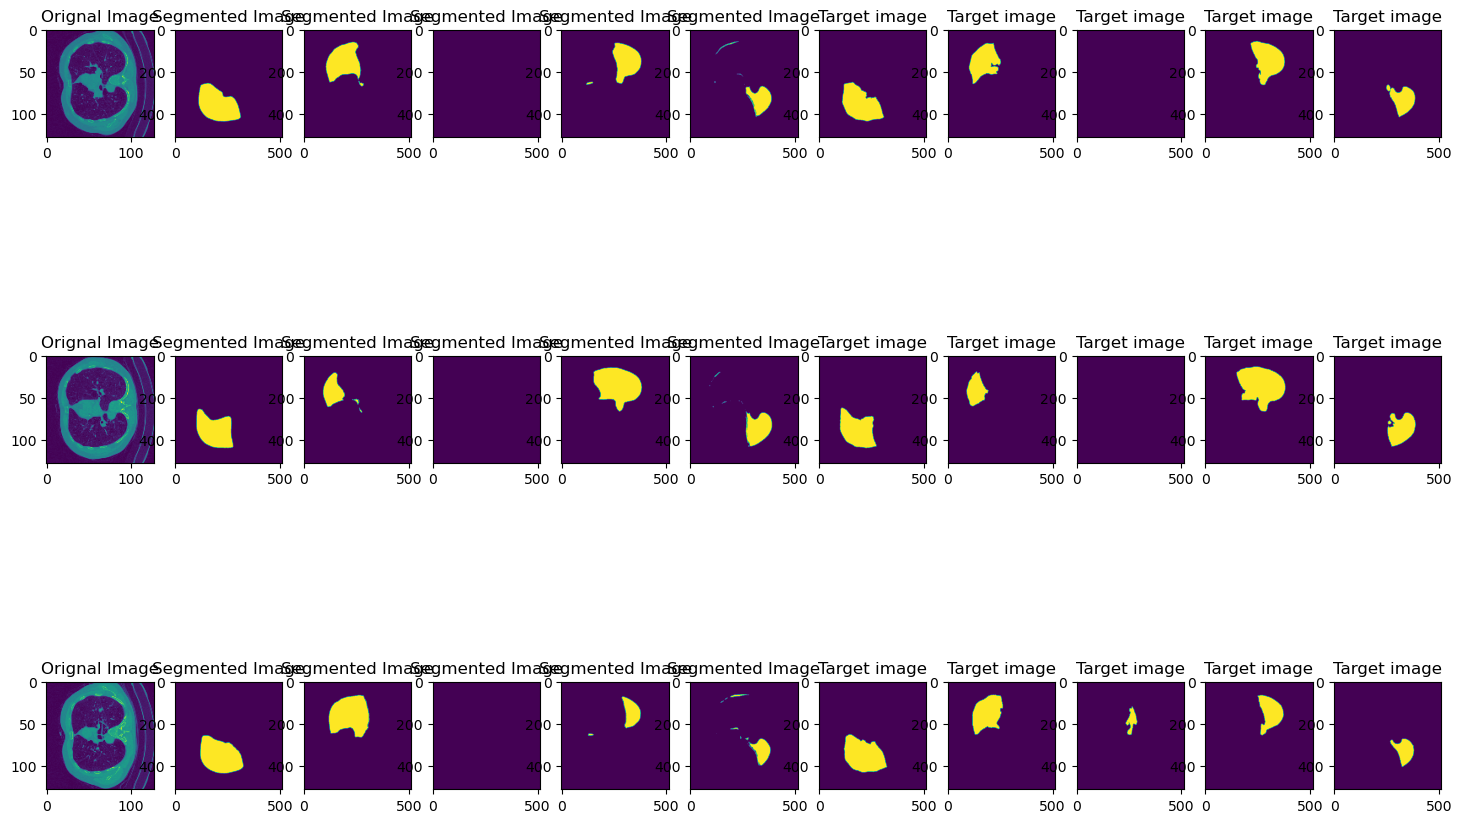

In [84]:
plot_examples(x_train, y_train)

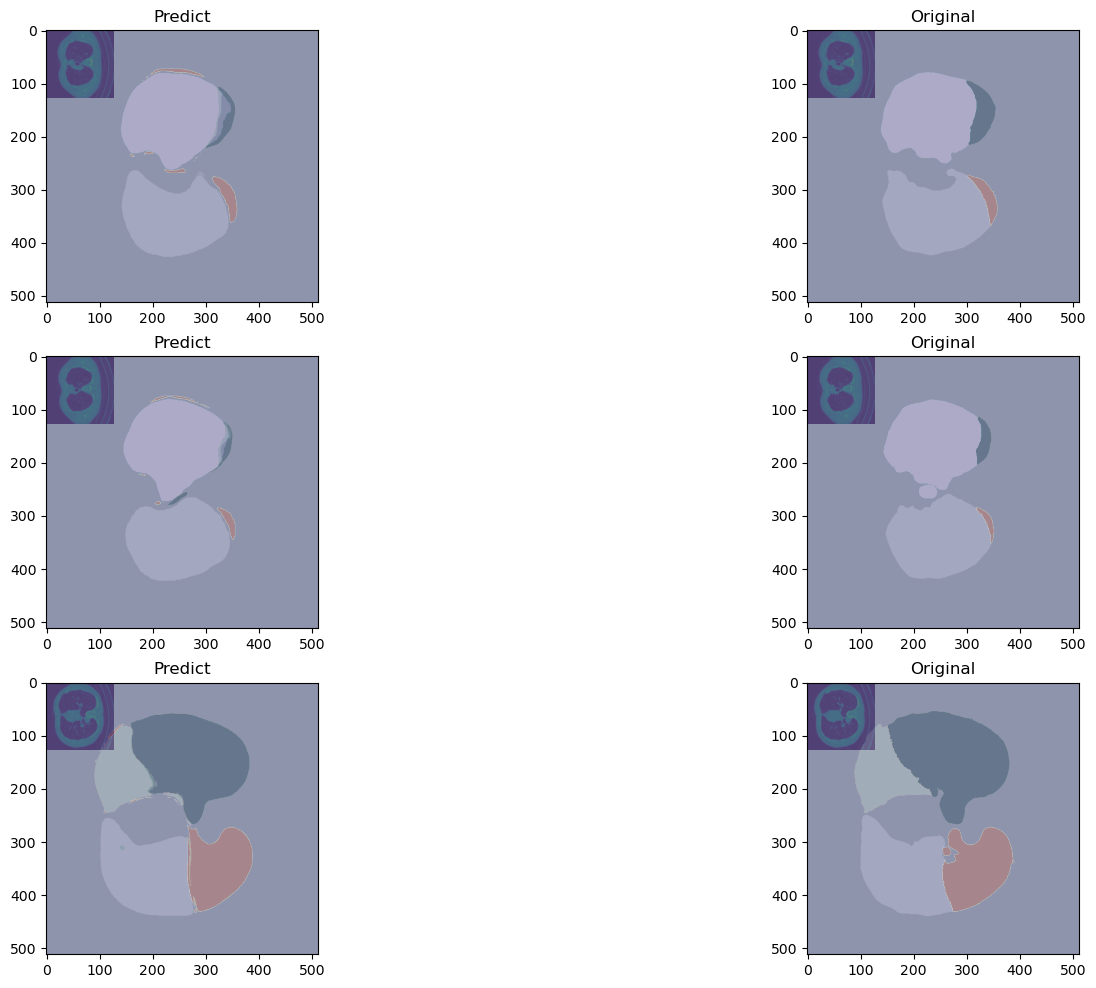

In [95]:
plot_examples_all(x_train, y_train)

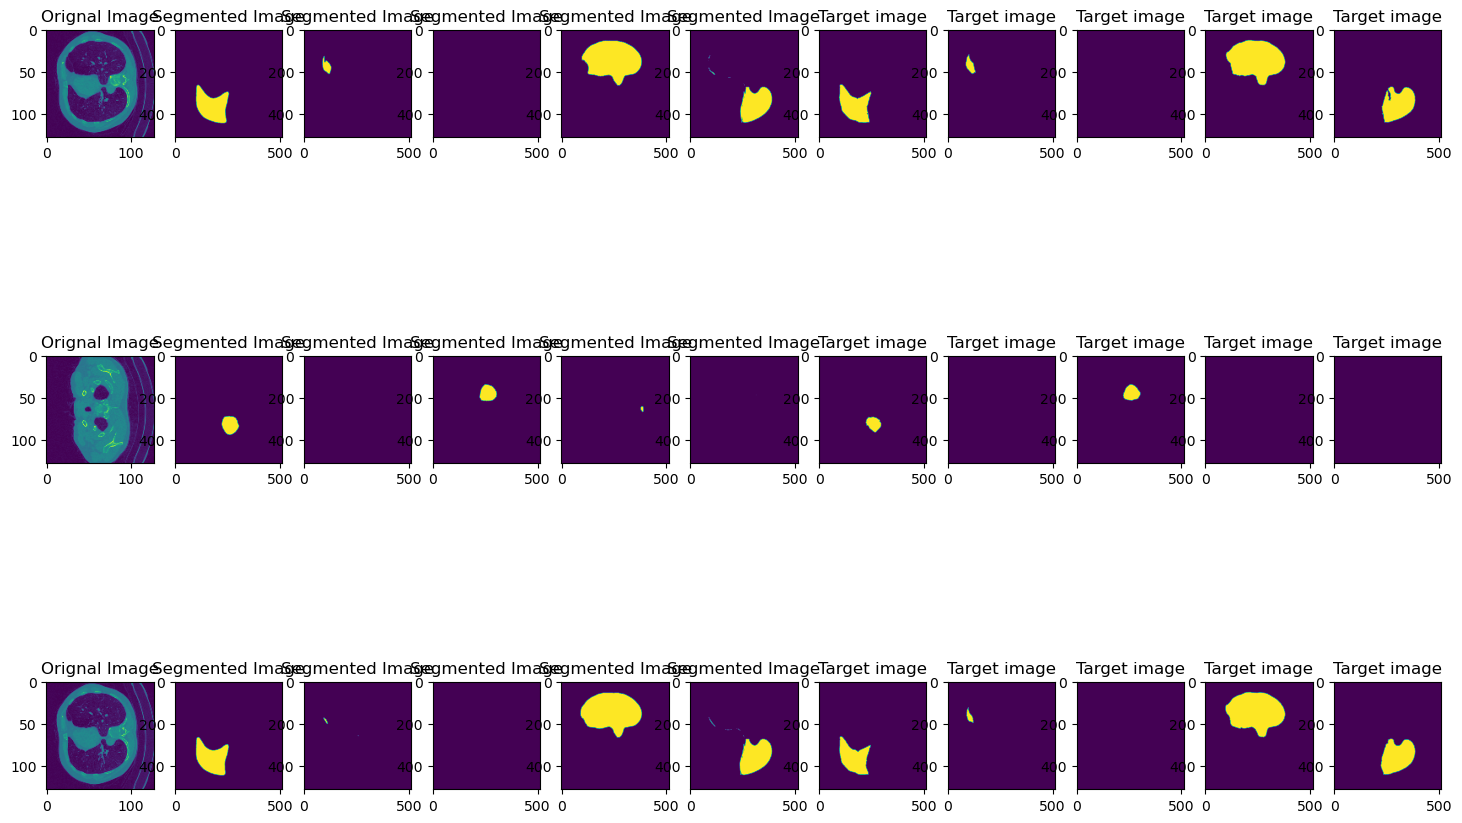

In [97]:
plot_examples(x_val, y_val)

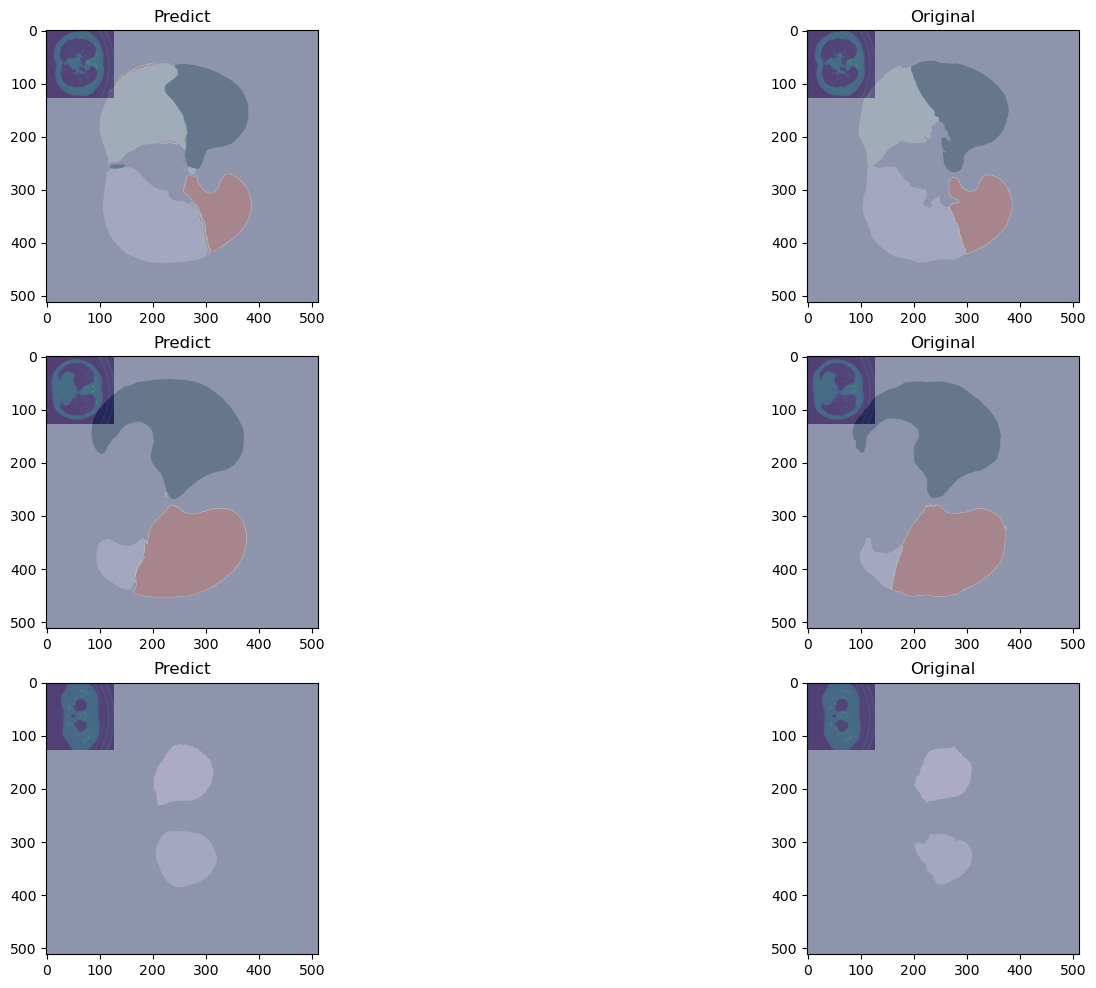

In [98]:
plot_examples_all(x_val, y_val)

In [ ]:
x_val

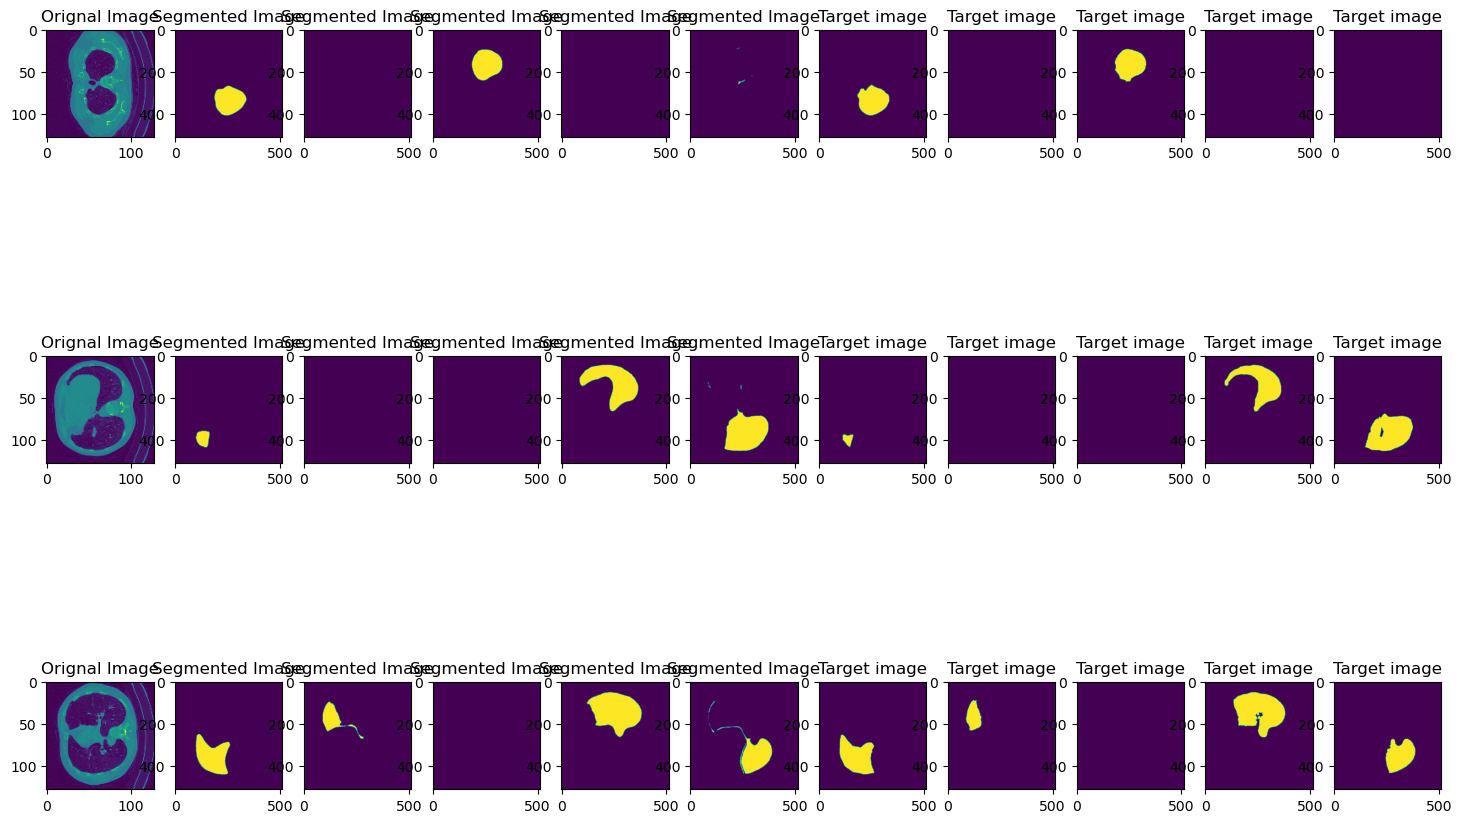

In [77]:
plot_examples(x_train, y_train)

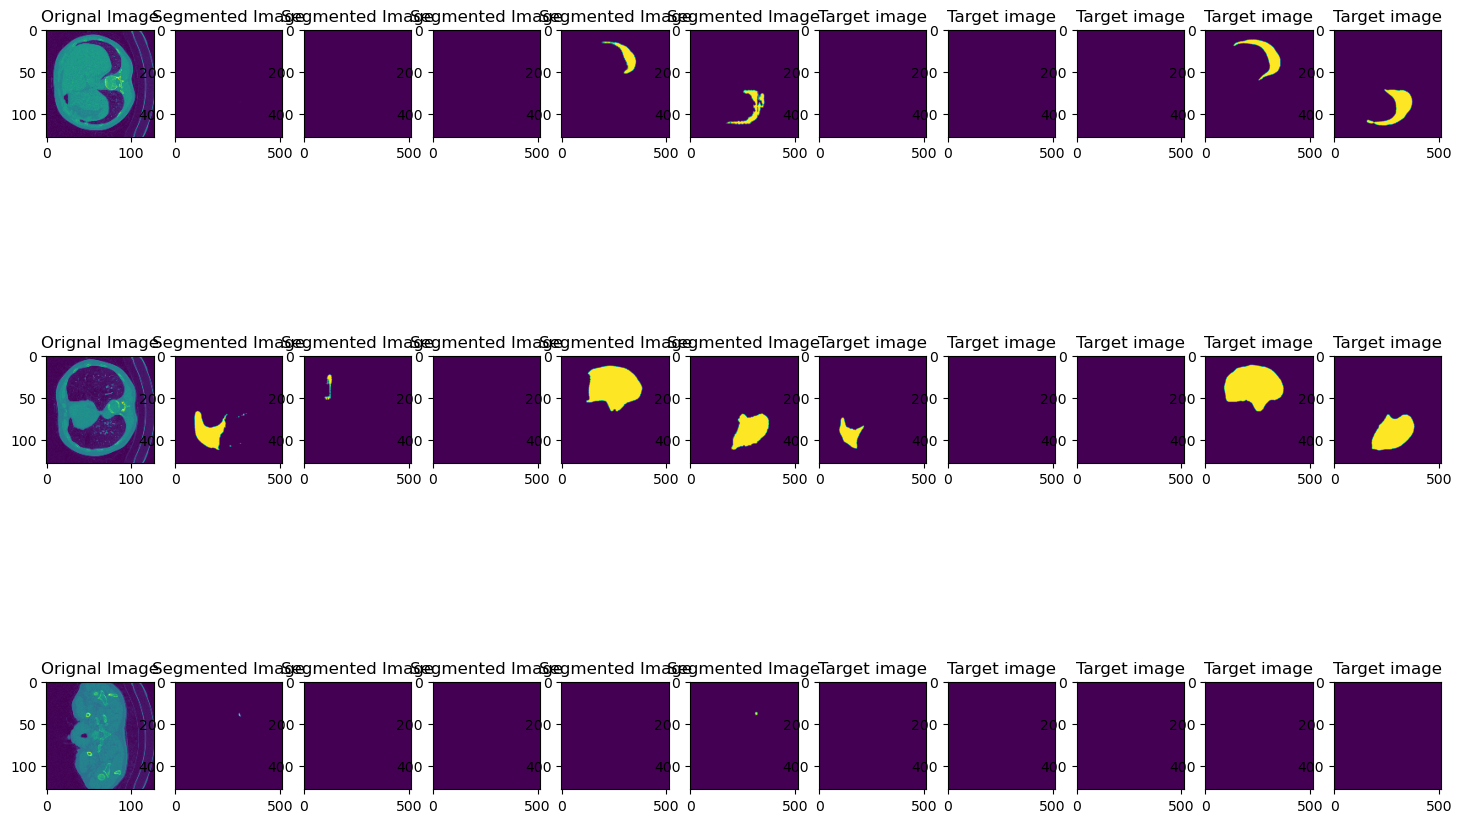

In [78]:
plot_examples(x_train, y_train)

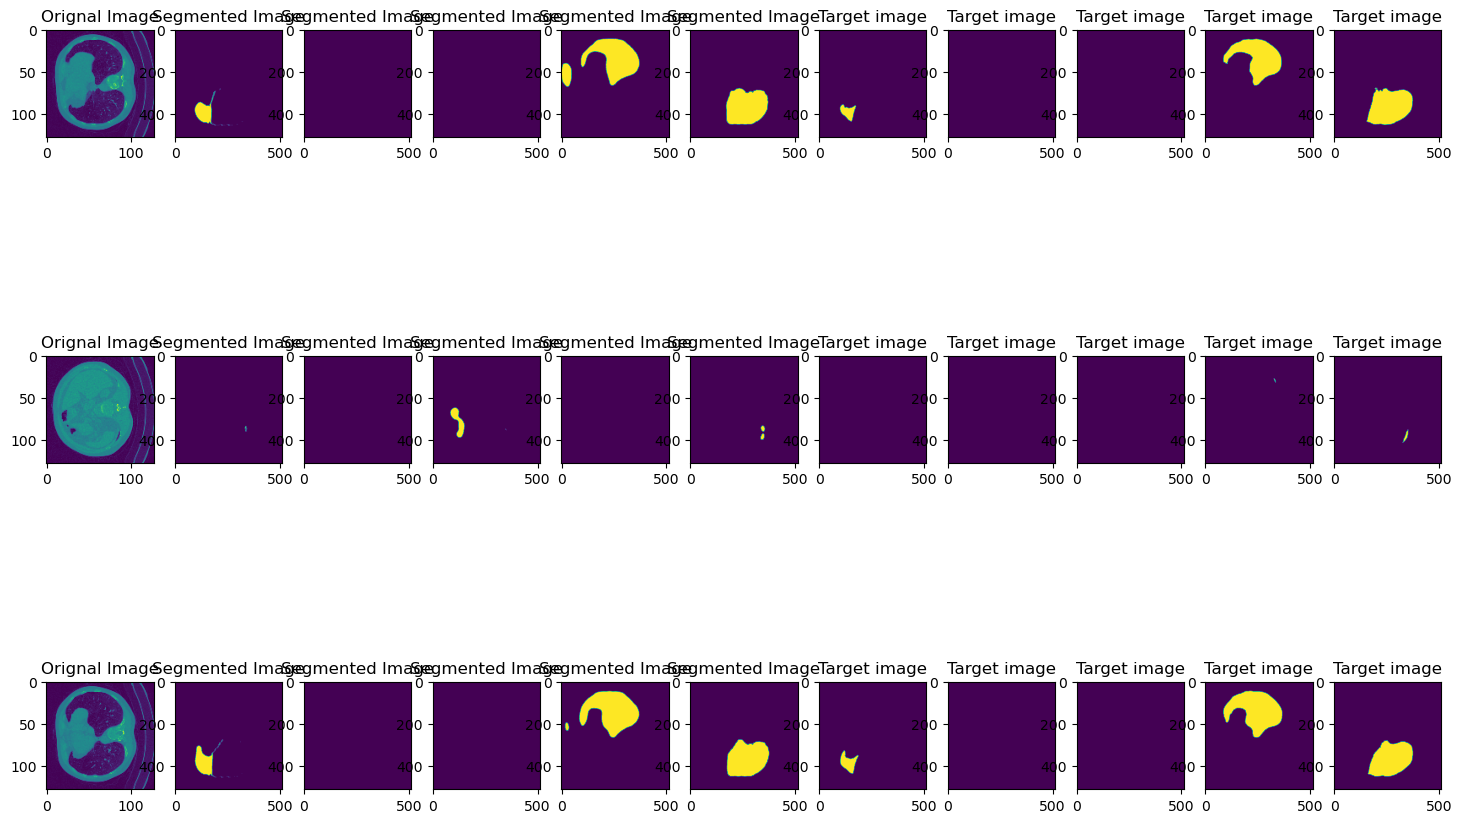

In [66]:
plot_examples(x_train, y_train)

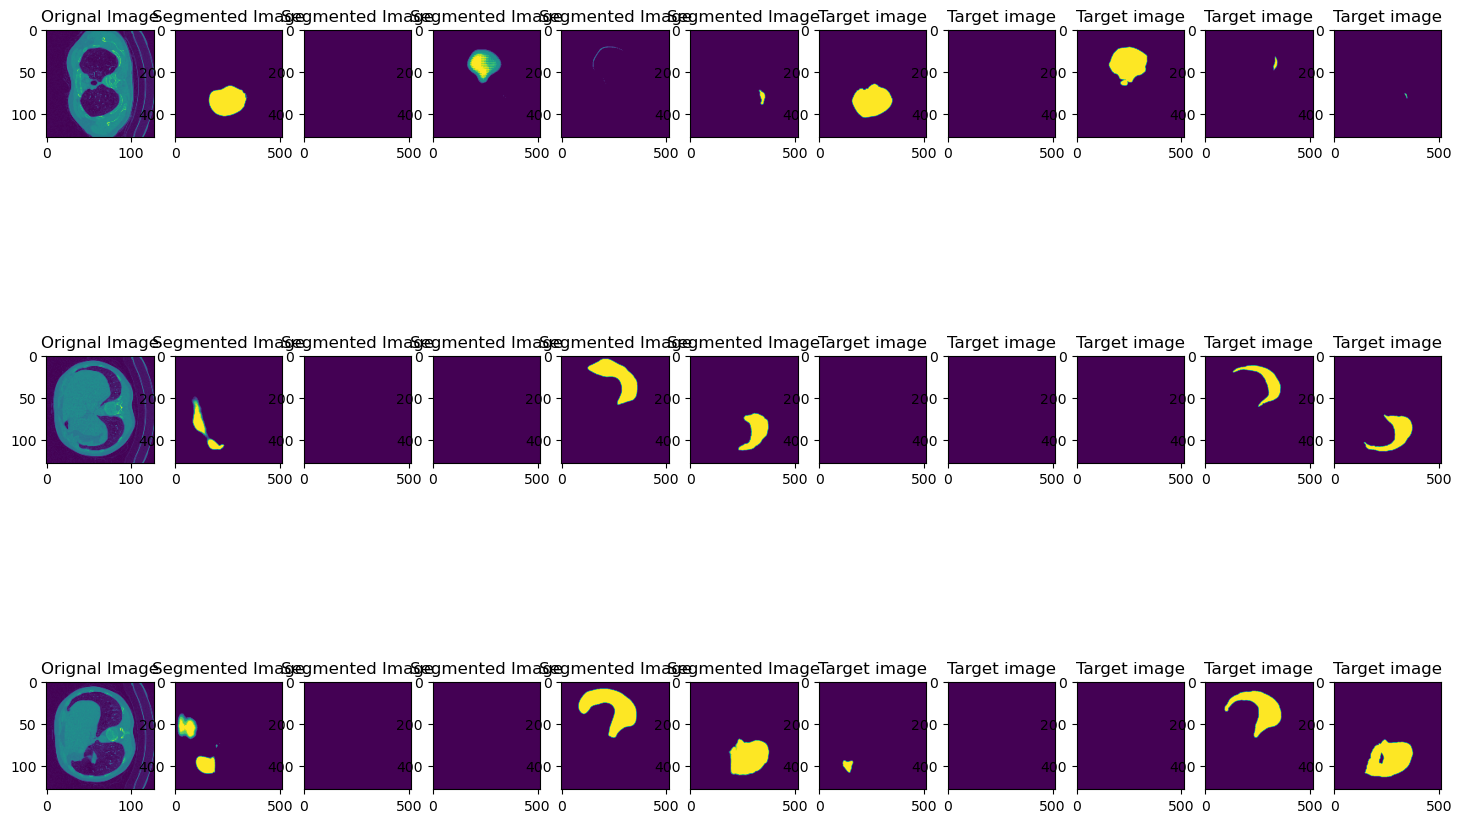

In [64]:
plot_examples(x_train, y_train)

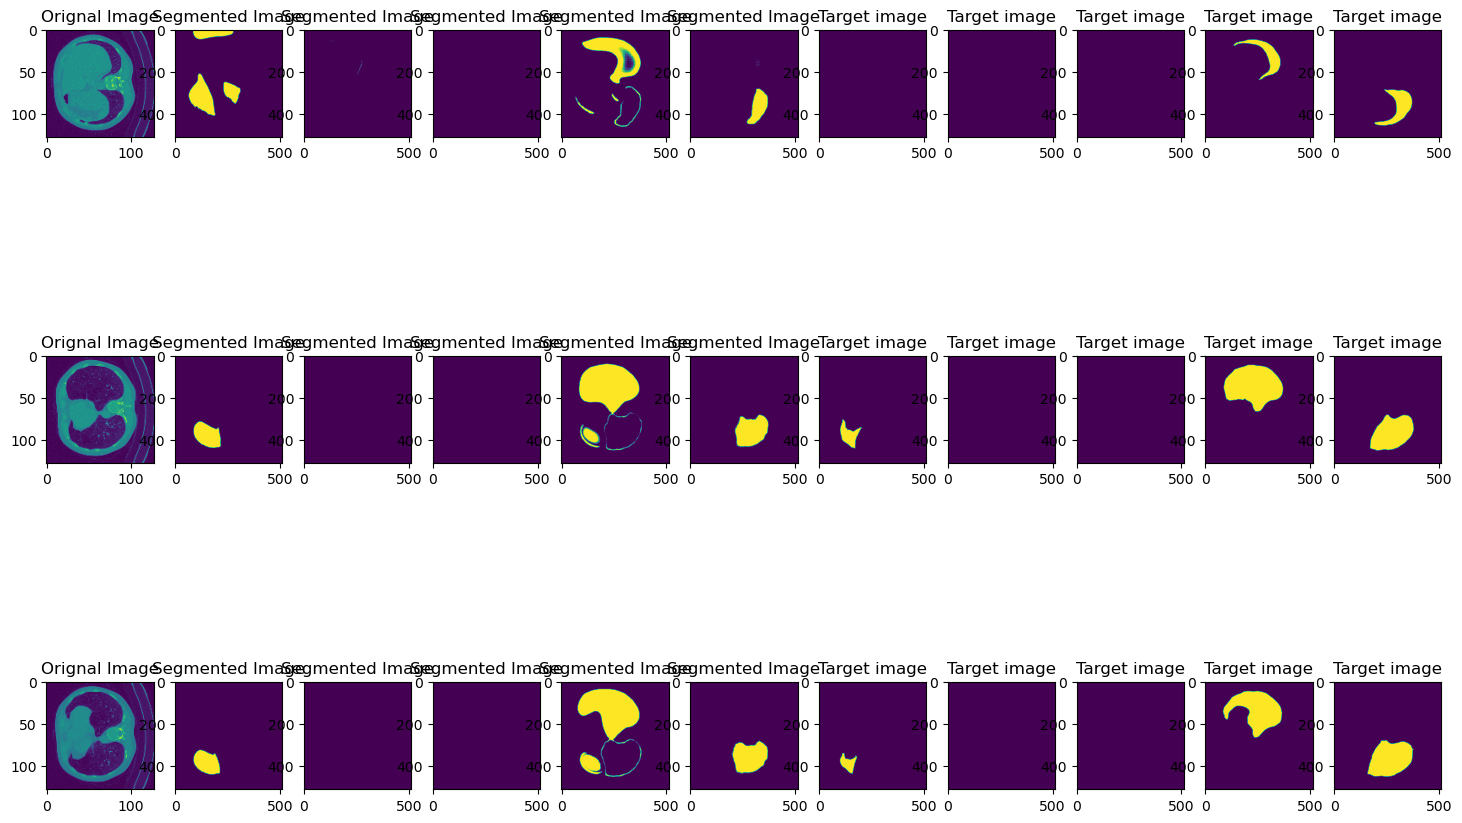

In [62]:
plot_examples(x_train, y_train)